In [ ]:
import os

from google.colab import drive
drive.mount('/content/drive')

os.environ["KAGGLE_USERNAME"] = 'datamollu'
os.environ["KAGGLE_KEY"] = "9dfd52a8f71dd4f527310af802c9dbf2"
!kaggle competitions download -c dogs-vs-cats

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import shutil
import zipfile


zipfile.ZipFile("dogs-vs-cats.zip").extractall()
zipfile.ZipFile("train.zip").extractall()
os.listdir(".")

['.config',
 'train.zip',
 'drive',
 'sampleSubmission.csv',
 'test1.zip',
 'train',
 'dogs-vs-cats.zip',
 'cats_vs_dogs_small',
 'sample_data']

In [ ]:
import pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")
def make_subset(subset_name, start_idx, end_idx):
  for category in ("cat", "dog"):
    dir = new_base_dir / subset_name / category
    os.makedirs(dir)
    fnames = [f"{category}.{i}.jpg"
              for i in range(start_idx, end_idx)]
    for fname in fnames:
      shutil.copyfile(src=original_dir / fname, dst=dir / fname)

make_subset("train", 0, 5000)
make_subset("validation", 5000, 7500)
make_subset("test", 7500, 10000)

FileExistsError: ignored

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

image_size = (224, 224)

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size = image_size,
    batch_size = 32
)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size = image_size,
    batch_size = 32
)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size = image_size,
    batch_size = 32
)

Found 10000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


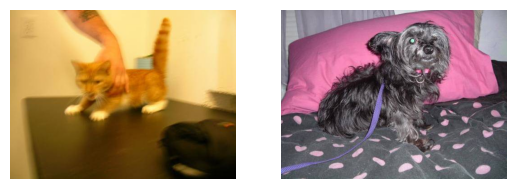

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img

f, axes = plt.subplots(1, 2)
axes[0].axis('off')
axes[0].imshow(load_img(os.path.join(new_base_dir, "train", "cat", "cat.0.jpg")))
axes[1].axis('off')
axes[1].imshow(load_img(os.path.join(new_base_dir, "train", "dog", "dog.0.jpg")))

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers


def batch_norm_block(x, depth, filter_size):
  x = layers.Conv2D(depth, filter_size, strides=1, use_bias=False, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  return x

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
for depth in [16, 32]:
  for i in range(4):
    x = batch_norm_block(x, depth, 3)
  x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary() # 모델 파라미터도 많고, 규제도 없어서 오버피팅 나버림

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      432       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 180, 180, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 16)      2304      
                                                             

In [ ]:
import tensorflow as tf

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("cat_vs_dogs_with_batchnorm.keras",
                                       save_best_only=True)
]

model.compile(optimizer='rmsprop',
              loss = 'binary_crossentropy',
              metrics = ["accuracy"])

history = model.fit(train_dataset,
                    epochs=20,
                    callbacks=callbacks,
                    validation_data=validation_dataset)

Epoch 1/20
313/313 [==============================] - 47s 105ms/step - loss: 1.6295 - accuracy: 0.5503 - val_loss: 0.6692 - val_accuracy: 0.5818
Epoch 2/20
313/313 [==============================] - 33s 106ms/step - loss: 0.6499 - accuracy: 0.6354 - val_loss: 0.6745 - val_accuracy: 0.5822
Epoch 3/20
313/313 [==============================] - 33s 106ms/step - loss: 0.5774 - accuracy: 0.7005 - val_loss: 0.6041 - val_accuracy: 0.6614
Epoch 4/20
313/313 [==============================] - 33s 105ms/step - loss: 0.5541 - accuracy: 0.7242 - val_loss: 0.6628 - val_accuracy: 0.6146
Epoch 5/20
313/313 [==============================] - 33s 106ms/step - loss: 0.5272 - accuracy: 0.7374 - val_loss: 0.5737 - val_accuracy: 0.6978
Epoch 6/20
313/313 [==============================] - 33s 106ms/step - loss: 0.5171 - accuracy: 0.7494 - val_loss: 0.5468 - val_accuracy: 0.7250
Epoch 7/20
313/313 [==============================] - 33s 106ms/step - loss: 0.4928 - accuracy: 0.7654 - val_loss: 0.6140 - val_ac

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers


data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"),
     layers.RandomRotation(0.1),
     layers.RandomZoom(0.2)]
)

def batch_norm_block(x, depth, filter_size):
  x = layers.Conv2D(depth, filter_size, strides=1, use_bias=False, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  return x

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
for depth in [16, 32, 64]:
  for i in range(2):
    x = batch_norm_block(x, depth, 3)
  x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary() # 오버피팅 방지를 위해 파라미터를 줄이고, 데이터 어그멘테이션과 dropout(p = 0.5)를 적용하였다

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_8 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_56 (Conv2D)          (None, 180, 180, 16)      432       
                                                                 
 batch_normalization_50 (Bat  (None, 180, 180, 16)     64        
 chNormalization)                                                
                                                                 
 activation_50 (Activation)  (None, 180, 180, 16)      0         
                                                           

In [ ]:
import tensorflow as tf

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("cat_vs_dogs_with_batchnorm.keras",
                                       save_best_only=True)
]

model.compile(optimizer='rmsprop',
              loss = 'binary_crossentropy',
              metrics = ["accuracy"])

history = model.fit(train_dataset,
                    epochs=40,
                    callbacks=callbacks,
                    validation_data=validation_dataset)

Epoch 1/40
313/313 [==============================] - 23s 65ms/step - loss: 1.2058 - accuracy: 0.5713 - val_loss: 0.6832 - val_accuracy: 0.6126
Epoch 2/40
313/313 [==============================] - 20s 65ms/step - loss: 0.7315 - accuracy: 0.6416 - val_loss: 0.6560 - val_accuracy: 0.6426
Epoch 3/40
313/313 [==============================] - 20s 64ms/step - loss: 0.5994 - accuracy: 0.6879 - val_loss: 0.5521 - val_accuracy: 0.7038
Epoch 4/40
313/313 [==============================] - 20s 64ms/step - loss: 0.5664 - accuracy: 0.7063 - val_loss: 0.5594 - val_accuracy: 0.7128
Epoch 5/40
313/313 [==============================] - 20s 64ms/step - loss: 0.5541 - accuracy: 0.7169 - val_loss: 0.5662 - val_accuracy: 0.7022
Epoch 6/40
313/313 [==============================] - 20s 64ms/step - loss: 0.5293 - accuracy: 0.7356 - val_loss: 0.5740 - val_accuracy: 0.7186
Epoch 7/40
313/313 [==============================] - 20s 64ms/step - loss: 0.5133 - accuracy: 0.7498 - val_loss: 0.5027 - val_accuracy:

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("cat_vs_dogs_with_batchnorm_extra_lr_decay.keras",
                                       save_best_only=True)
]

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss = 'binary_crossentropy',
              metrics = ["accuracy"])

history = model.fit(train_dataset,
                    epochs=10,
                    callbacks=callbacks,
                    validation_data=validation_dataset)

Epoch 1/10
313/313 [==============================] - 23s 65ms/step - loss: 0.1604 - accuracy: 0.9381 - val_loss: 0.1832 - val_accuracy: 0.9236
Epoch 2/10
313/313 [==============================] - 20s 64ms/step - loss: 0.1572 - accuracy: 0.9378 - val_loss: 0.1710 - val_accuracy: 0.9286
Epoch 3/10
313/313 [==============================] - 20s 64ms/step - loss: 0.1537 - accuracy: 0.9386 - val_loss: 0.2009 - val_accuracy: 0.9224
Epoch 4/10
313/313 [==============================] - 20s 64ms/step - loss: 0.1601 - accuracy: 0.9388 - val_loss: 0.2576 - val_accuracy: 0.9070
Epoch 5/10
313/313 [==============================] - 20s 64ms/step - loss: 0.1545 - accuracy: 0.9374 - val_loss: 0.1795 - val_accuracy: 0.9258
Epoch 6/10
313/313 [==============================] - 20s 64ms/step - loss: 0.1544 - accuracy: 0.9399 - val_loss: 0.1872 - val_accuracy: 0.9228
Epoch 7/10
313/313 [==============================] - 20s 64ms/step - loss: 0.1497 - accuracy: 0.9396 - val_loss: 0.1904 - val_accuracy:

In [ ]:
def show_graph(history):
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  epochs = range(1, len(accuracy)+1)
  plt.plot(epochs, accuracy, "bo", label="training accuracy")
  plt.plot(epochs, val_accuracy, "b", label="validation accuracy")
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, "bo", label="training loss")
  plt.plot(epochs, val_loss, "b", label="validation loss")
  plt.legend()
  plt.show()

In [ ]:
def show_test_acc(model, test_dataset):
  test_model = model
  test_loss, test_acc = test_model.evaluate(test_dataset)
  print(f"테스트 정확도 : {test_acc}")

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("cat_vs_dogs_with_batchnorm_extra_lr_decay_1.keras",
                                       save_best_only=True)
]

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00005),
              loss = 'binary_crossentropy',
              metrics = ["accuracy"])

history = model.fit(train_dataset,
                    epochs=10,
                    callbacks=callbacks,
                    validation_data=validation_dataset)

Epoch 1/10
313/313 [==============================] - 23s 65ms/step - loss: 0.1464 - accuracy: 0.9435 - val_loss: 0.1736 - val_accuracy: 0.9298
Epoch 2/10
313/313 [==============================] - 20s 65ms/step - loss: 0.1424 - accuracy: 0.9440 - val_loss: 0.1803 - val_accuracy: 0.9292
Epoch 3/10
313/313 [==============================] - 20s 64ms/step - loss: 0.1460 - accuracy: 0.9424 - val_loss: 0.1712 - val_accuracy: 0.9306
Epoch 4/10
313/313 [==============================] - 20s 64ms/step - loss: 0.1461 - accuracy: 0.9434 - val_loss: 0.1819 - val_accuracy: 0.9260
Epoch 5/10
313/313 [==============================] - 20s 64ms/step - loss: 0.1409 - accuracy: 0.9451 - val_loss: 0.1792 - val_accuracy: 0.9268
Epoch 6/10
313/313 [==============================] - 20s 64ms/step - loss: 0.1433 - accuracy: 0.9447 - val_loss: 0.1747 - val_accuracy: 0.9282
Epoch 7/10
313/313 [==============================] - 20s 64ms/step - loss: 0.1460 - accuracy: 0.9446 - val_loss: 0.1656 - val_accuracy:

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"테스트 정확도 : {test_acc}")

157/157 [==============================] - 3s 16ms/step - loss: 0.1917 - accuracy: 0.9272
테스트 정확도 : 0.9272000193595886


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers


data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"),
     layers.RandomRotation(0.1),
     layers.RandomZoom(0.2)]
)

def batch_norm_block(x, depth, filter_size):
  x = layers.Conv2D(depth, filter_size, strides=1, use_bias=False, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  return x

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
for depth in [16, 32, 64]:
  for i in range(2):
    x = batch_norm_block(x, depth, 3)
  x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 sequential_7 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_11 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_74 (Conv2D)          (None, 180, 180, 16)      432       
                                                                 
 batch_normalization_68 (Bat  (None, 180, 180, 16)     64        
 chNormalization)                                                
                                                                 
 activation_68 (Activation)  (None, 180, 180, 16)      0         
                                                          

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("cat_vs_dogs_last_double_pool.keras",
                                       save_best_only=True)
]

model.compile(optimizer="rmsprop",
              loss = 'binary_crossentropy',
              metrics = ["accuracy"])

history = model.fit(train_dataset,
                    epochs=20,
                    callbacks=callbacks,
                    validation_data=validation_dataset)

Epoch 1/20
313/313 [==============================] - 23s 66ms/step - loss: 0.8274 - accuracy: 0.5843 - val_loss: 1.0250 - val_accuracy: 0.5024
Epoch 2/20
313/313 [==============================] - 20s 64ms/step - loss: 0.6253 - accuracy: 0.6576 - val_loss: 0.5867 - val_accuracy: 0.6848
Epoch 3/20
313/313 [==============================] - 20s 63ms/step - loss: 0.5800 - accuracy: 0.6964 - val_loss: 0.5356 - val_accuracy: 0.7280
Epoch 4/20
313/313 [==============================] - 20s 63ms/step - loss: 0.5530 - accuracy: 0.7167 - val_loss: 0.5621 - val_accuracy: 0.7134
Epoch 5/20
313/313 [==============================] - 20s 64ms/step - loss: 0.5174 - accuracy: 0.7462 - val_loss: 0.4683 - val_accuracy: 0.7696
Epoch 6/20
313/313 [==============================] - 20s 64ms/step - loss: 0.4919 - accuracy: 0.7575 - val_loss: 0.6338 - val_accuracy: 0.7044
Epoch 7/20
313/313 [==============================] - 20s 63ms/step - loss: 0.4648 - accuracy: 0.7833 - val_loss: 0.5473 - val_accuracy:

In [ ]:
history = model.fit(train_dataset,
                    epochs=10,
                    callbacks=callbacks,
                    validation_data=validation_dataset)

Epoch 1/10
313/313 [==============================] - 20s 64ms/step - loss: 0.3057 - accuracy: 0.8679 - val_loss: 0.4761 - val_accuracy: 0.8306
Epoch 2/10
313/313 [==============================] - 20s 64ms/step - loss: 0.2935 - accuracy: 0.8793 - val_loss: 0.9319 - val_accuracy: 0.6956
Epoch 3/10
313/313 [==============================] - 20s 64ms/step - loss: 0.2917 - accuracy: 0.8782 - val_loss: 0.3028 - val_accuracy: 0.8778
Epoch 4/10
313/313 [==============================] - 20s 63ms/step - loss: 0.2828 - accuracy: 0.8834 - val_loss: 0.5194 - val_accuracy: 0.7958
Epoch 5/10
313/313 [==============================] - 20s 63ms/step - loss: 0.2828 - accuracy: 0.8827 - val_loss: 1.3516 - val_accuracy: 0.6658
Epoch 6/10
313/313 [==============================] - 20s 64ms/step - loss: 0.2704 - accuracy: 0.8836 - val_loss: 0.2465 - val_accuracy: 0.8982
Epoch 7/10
313/313 [==============================] - 20s 63ms/step - loss: 0.2677 - accuracy: 0.8869 - val_loss: 0.2742 - val_accuracy:

In [ ]:
history = model.fit(train_dataset,
                    epochs=20,
                    callbacks=callbacks,
                    validation_data=validation_dataset)

Epoch 1/20
313/313 [==============================] - 20s 64ms/step - loss: 0.2494 - accuracy: 0.8963 - val_loss: 0.3562 - val_accuracy: 0.8480
Epoch 2/20
313/313 [==============================] - 20s 65ms/step - loss: 0.2484 - accuracy: 0.8990 - val_loss: 0.2162 - val_accuracy: 0.9054
Epoch 3/20
313/313 [==============================] - 20s 63ms/step - loss: 0.2397 - accuracy: 0.9037 - val_loss: 0.3805 - val_accuracy: 0.8364
Epoch 4/20
313/313 [==============================] - 20s 63ms/step - loss: 0.2335 - accuracy: 0.9027 - val_loss: 0.2645 - val_accuracy: 0.8942
Epoch 5/20
313/313 [==============================] - 20s 64ms/step - loss: 0.2398 - accuracy: 0.9061 - val_loss: 0.2926 - val_accuracy: 0.8858
Epoch 6/20
313/313 [==============================] - 20s 64ms/step - loss: 0.2336 - accuracy: 0.9045 - val_loss: 0.2384 - val_accuracy: 0.9018
Epoch 7/20
313/313 [==============================] - 20s 64ms/step - loss: 0.2260 - accuracy: 0.9039 - val_loss: 0.2578 - val_accuracy:

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers


data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"),
     layers.RandomRotation(0.1),
     layers.RandomZoom(0.2)]
)

def batch_norm_block(x, depth, filter_size):
  x = layers.Conv2D(depth, filter_size, strides=1, use_bias=False, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  return x

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
for depth in [16, 32, 64]:
  for i in range(2):
    x = batch_norm_block(x, depth, 3)
  x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 sequential_10 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_14 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_92 (Conv2D)          (None, 180, 180, 16)      432       
                                                                 
 batch_normalization_86 (Bat  (None, 180, 180, 16)     64        
 chNormalization)                                                
                                                                 
 activation_86 (Activation)  (None, 180, 180, 16)      0         
                                                          

In [ ]:
def schedular(epoch, lr):
  if(epoch == 30):
    return lr*0.1
  elif(epoch == 40):
    return lr*0.1
  elif(epoch == 50):
    return lr*0.1
  return lr

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("cat_vs_dogs_lr_decay.keras",
                                       save_best_only=True),
    tf.keras.callbacks.LearningRateScheduler(schedular, verbose=0)
]

model.compile(optimizer="rmsprop",
              loss = 'binary_crossentropy',
              metrics = ["accuracy"])

history = model.fit(train_dataset,
                    epochs=60,
                    callbacks=callbacks,
                    validation_data=validation_dataset)

Epoch 1/60
313/313 [==============================] - 23s 65ms/step - loss: 1.0441 - accuracy: 0.5887 - val_loss: 0.7025 - val_accuracy: 0.5288 - lr: 0.0010
Epoch 2/60
313/313 [==============================] - 20s 64ms/step - loss: 0.6428 - accuracy: 0.6704 - val_loss: 0.6373 - val_accuracy: 0.6762 - lr: 0.0010
Epoch 3/60
313/313 [==============================] - 20s 64ms/step - loss: 0.5770 - accuracy: 0.7091 - val_loss: 0.5623 - val_accuracy: 0.7074 - lr: 0.0010
Epoch 4/60
313/313 [==============================] - 20s 64ms/step - loss: 0.5322 - accuracy: 0.7309 - val_loss: 0.5596 - val_accuracy: 0.7326 - lr: 0.0010
Epoch 5/60
313/313 [==============================] - 20s 64ms/step - loss: 0.5035 - accuracy: 0.7584 - val_loss: 0.5639 - val_accuracy: 0.7240 - lr: 0.0010
Epoch 6/60
313/313 [==============================] - 20s 64ms/step - loss: 0.4793 - accuracy: 0.7696 - val_loss: 0.4982 - val_accuracy: 0.7508 - lr: 0.0010
Epoch 7/60
313/313 [==============================] - 20s 

In [ ]:
from tensorflow.python.ops.math_ops import xdivy
from tensorflow import keras
from tensorflow.keras import layers


data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"),
     layers.RandomRotation(0.1),
     layers.RandomZoom(0.2)]
)

def residual_block(x, depth, filter_size):
  residual = x
  x = layers.Conv2D(depth, filter_size, strides=1, use_bias=False, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.Conv2D(depth, filter_size, strides=1, use_bias=False, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  residual = layers.Conv2D(depth, 1, strides=2)(residual)
  x = layers.add([x, residual])
  x = layers.Activation("relu")(x)
  return x

inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(64, 7, strides=2, use_bias=False, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
for depth in [32, 64, 128, 256]:
  x = residual_block(x, depth, 3)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 sequential_1 (Sequential)   (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['sequential_1[0][0]']        
                                                                                                  
 conv2d_13 (Conv2D)          (None, 112, 112, 64)         9408      ['rescaling_1[0][0]']         
                                                                                            

In [ ]:
import tensorflow as tf


callbacks = [
    tf.keras.callbacks.ModelCheckpoint("cat_vs_dogs_residual_connection.x",
                                       save_best_only=True),
    keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5)
]

model.compile(optimizer='rmsprop',
              loss = 'binary_crossentropy',
              metrics = ["accuracy"])

history = model.fit(train_dataset,
                    epochs=60,
                    callbacks=callbacks,
                    validation_data=validation_dataset)

Epoch 1/60
313/313 [==============================] - 38s 104ms/step - loss: 0.6149 - accuracy: 0.6706 - val_loss: 1.1080 - val_accuracy: 0.5682 - lr: 0.0010
Epoch 2/60
313/313 [==============================] - 28s 90ms/step - loss: 0.5767 - accuracy: 0.6972 - val_loss: 1.2649 - val_accuracy: 0.5210 - lr: 0.0010
Epoch 3/60
313/313 [==============================] - 33s 105ms/step - loss: 0.5377 - accuracy: 0.7280 - val_loss: 0.6157 - val_accuracy: 0.7072 - lr: 0.0010
Epoch 4/60
313/313 [==============================] - 33s 106ms/step - loss: 0.4991 - accuracy: 0.7631 - val_loss: 0.5110 - val_accuracy: 0.7552 - lr: 0.0010
Epoch 5/60
313/313 [==============================] - 29s 92ms/step - loss: 0.4657 - accuracy: 0.7785 - val_loss: 0.6584 - val_accuracy: 0.7020 - lr: 0.0010
Epoch 6/60
313/313 [==============================] - 29s 93ms/step - loss: 0.4406 - accuracy: 0.7933 - val_loss: 0.5229 - val_accuracy: 0.7308 - lr: 0.0010
Epoch 7/60
313/313 [==============================] - 3

In [ ]:
test_model = keras.saving.load_model("cat_vs_dogs_residual_connection.x")

In [ ]:
show_test_acc(model, test_dataset)

157/157 [==============================] - 4s 26ms/step - loss: 0.1290 - accuracy: 0.9488
테스트 정확도 : 0.9488000273704529


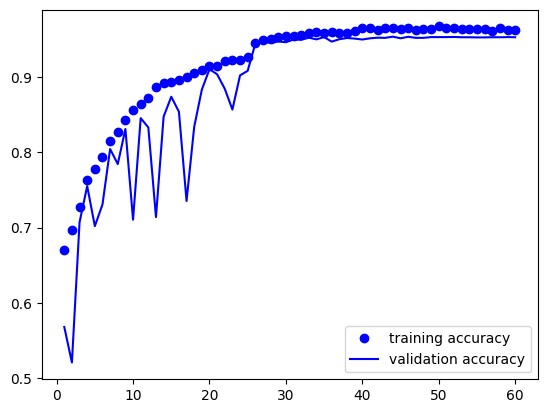

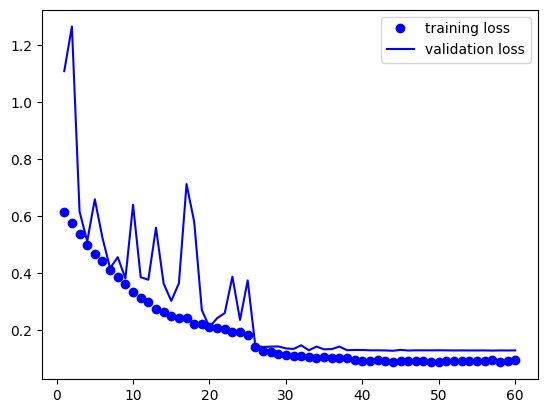

In [ ]:
import matplotlib.pyplot as plt

show_graph(history)

# cutmix data augmentation 기법 사용해보기


In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow as tf

image_size = (224, 224)

AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 224

def preprocess_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.image.convert_image_dtype(image, tf.float32) / 255.0
    label = tf.cast(label, tf.float32)
    return image, label


train_ds_one = (
    image_dataset_from_directory(
    new_base_dir / "train", label_mode="categorical", batch_size=None).shuffle(1024).map(preprocess_image, num_parallel_calls=AUTO)
)

train_ds_two = (
    image_dataset_from_directory(
    new_base_dir / "train", label_mode="categorical", batch_size=None).shuffle(1024).map(preprocess_image, num_parallel_calls=AUTO)
)



train_ds_simple = image_dataset_from_directory(
    new_base_dir / "train", label_mode="categorical", batch_size=None
).map(preprocess_image, num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)

val_ds = image_dataset_from_directory(
    new_base_dir / "validation", label_mode="categorical", batch_size=None
).map(preprocess_image, num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)

test_ds = image_dataset_from_directory(
    new_base_dir / "test", label_mode="categorical", batch_size=None
).map(preprocess_image, num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)

Found 10000 files belonging to 2 classes.
(224, 224, 3)
Found 10000 files belonging to 2 classes.
(224, 224, 3)
Found 10000 files belonging to 2 classes.
(224, 224, 3)
Found 5000 files belonging to 2 classes.
(224, 224, 3)
Found 5000 files belonging to 2 classes.
(224, 224, 3)


In [ ]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2): # beta 함수 값 가져오기
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


@tf.function
def get_box(lambda_value):
    cut_rat = tf.math.sqrt(1.0 - lambda_value)

    cut_w = IMG_SIZE * cut_rat  # rw
    cut_w = tf.cast(cut_w, tf.int32)

    cut_h = IMG_SIZE * cut_rat  # rh
    cut_h = tf.cast(cut_h, tf.int32)

    cut_x = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # rx
    cut_y = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # ry

    boundaryx1 = tf.clip_by_value(cut_x[0] - cut_w // 2, 0, IMG_SIZE)
    boundaryy1 = tf.clip_by_value(cut_y[0] - cut_h // 2, 0, IMG_SIZE)
    bbx2 = tf.clip_by_value(cut_x[0] + cut_w // 2, 0, IMG_SIZE)
    bby2 = tf.clip_by_value(cut_y[0] + cut_h // 2, 0, IMG_SIZE)  # 사각형 꼭짓점 밑 h, w 구하는데 0 ~ IMG_SIZE 범위 유지하도록 clip_by_value 메서드 사용

    target_h = bby2 - boundaryy1
    if target_h == 0:
        target_h += 1

    target_w = bbx2 - boundaryx1
    if target_w == 0:
        target_w += 1

    return boundaryx1, boundaryy1, target_h, target_w


@tf.function
def cutmix(train_ds_one, train_ds_two):
    (image1, label1), (image2, label2) = train_ds_one, train_ds_two

    alpha = [0.25]
    beta = [0.25]

    # Get a sample from the Beta distribution
    lambda_value = sample_beta_distribution(1, alpha, beta)

    # Define Lambda
    lambda_value = lambda_value[0][0]

    # Get the bounding box offsets, heights and widths
    boundaryx1, boundaryy1, target_h, target_w = get_box(lambda_value) # bounding box에 대한 정보를 beta분포로부터 추출한 lambda_value로 얻어낸다(수식 위 참고)

    # Get a patch from the second image (`image2`)
    crop2 = tf.image.crop_to_bounding_box(
        image2, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image2` patch (`crop2`) with the same offset
    image2 = tf.image.pad_to_bounding_box(
        crop2, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )
    # Get a patch from the first image (`image1`)
    crop1 = tf.image.crop_to_bounding_box(
        image1, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image1` patch (`crop1`) with the same offset
    img1 = tf.image.pad_to_bounding_box(
        crop1, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )

    # Modify the first image by subtracting the patch from `image1`
    # (before applying the `image2` patch)
    image1 = image1 - img1
    # Add the modified `image1` and `image2`  together to get the CutMix image
    image = image1 + image2

    # Adjust Lambda in accordance to the pixel ration
    lambda_value = 1 - (target_w * target_h) / (IMG_SIZE * IMG_SIZE)
    lambda_value = tf.cast(lambda_value, tf.float32)

    # Combine the labels of both images
    label = lambda_value * label1 + (1 - lambda_value) * label2
    return image, label

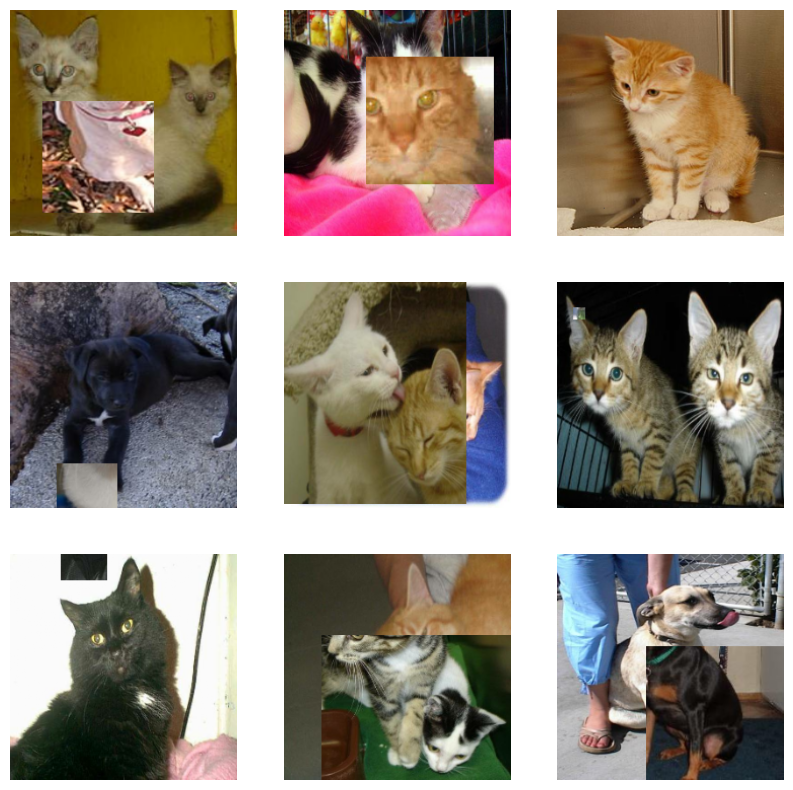

In [ ]:
import matplotlib.pyplot as plt

train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

# Create the new dataset using our `cutmix` utility
train_ds_cmu = (
    train_ds.shuffle(1024)
    .map(cutmix, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Let's preview 9 samples from the dataset
image_batch, label_batch = next(iter(train_ds_cmu))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i])
    plt.axis("off")

In [ ]:
from tensorflow.python.ops.math_ops import xdivy
from tensorflow import keras
from tensorflow.keras import layers


def residual_block(x, depth, filter_size):
  residual = x
  x = layers.Conv2D(depth, filter_size, strides=1, use_bias=False, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.Conv2D(depth, filter_size, strides=1, use_bias=False, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPooling2D(pool_size=2)(x)
  residual = layers.Conv2D(depth, 1, strides=2)(residual)
  x = layers.add([x, residual])
  x = layers.Activation("relu")(x)
  return x

inputs = keras.Input(shape=(224, 224, 3))
x = layers.Conv2D(64, 7, strides=2, use_bias=False, padding="same")(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
for depth in [32, 64, 128, 256]:
  x = residual_block(x, depth, 3)
x = layers.Flatten()(x)
outputs = layers.Dense(2, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_1 (Conv2D)           (None, 112, 112, 64)         9408      ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 64)         256       ['conv2d_1[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 112, 112, 64)         0         ['batch_normalization[0][0

In [ ]:
import tensorflow as tf


callbacks = [
    tf.keras.callbacks.ModelCheckpoint("cat_vs_dogs_residual_connection.x",
                                       save_best_only=True),
    keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5)
]

model.compile(optimizer='rmsprop',
              loss = 'categorical_crossentropy',
              metrics = ["accuracy"])

history = model.fit(train_ds_cmu,
                    epochs=60,
                    callbacks=callbacks,
                    validation_data=val_ds)

Epoch 1/60
313/313 [==============================] - 39s 103ms/step - loss: 0.6711 - accuracy: 0.6070 - val_loss: 0.8648 - val_accuracy: 0.6034 - lr: 0.0010
Epoch 2/60
313/313 [==============================] - 31s 93ms/step - loss: 0.6420 - accuracy: 0.6492 - val_loss: 0.6825 - val_accuracy: 0.5976 - lr: 0.0010
Epoch 3/60
313/313 [==============================] - 31s 92ms/step - loss: 0.6240 - accuracy: 0.6670 - val_loss: 0.6194 - val_accuracy: 0.6592 - lr: 0.0010
Epoch 4/60
313/313 [==============================] - 28s 81ms/step - loss: 0.6100 - accuracy: 0.6807 - val_loss: 0.6720 - val_accuracy: 0.6124 - lr: 0.0010
Epoch 5/60
313/313 [==============================] - 32s 93ms/step - loss: 0.5876 - accuracy: 0.7125 - val_loss: 0.5928 - val_accuracy: 0.6758 - lr: 0.0010
Epoch 6/60
313/313 [==============================] - 28s 81ms/step - loss: 0.5724 - accuracy: 0.7239 - val_loss: 0.6457 - val_accuracy: 0.6526 - lr: 0.0010
Epoch 7/60
313/313 [==============================] - 28s

KeyboardInterrupt: ignored